In [1]:
import cv2
import os
import sys
import argparse

from skimage import io
from skimage import exposure
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from tqdm import tqdm
import time

from pathlib import Path
import shutil

In [2]:
print('OpenCV-Python Lib Version:', cv2.__version__)
print('Python Version:',sys.version)

OpenCV-Python Lib Version: 3.4.11
Python Version: 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]


# Util Functions

In [3]:
def show(img):
    io.imshow(img)
    plt.show()

### Splitting test and train data from the .txt files provided

In [4]:
def read_txt(path):
    with open(path) as f:
        content = [line.replace("\n","") for line in f.readlines()]
        return content

In [5]:
def create_folder(folname):
    try:
        os.mkdir(folname)
    except FileExistsError:
#         print(folname,'folder already exist')
        pass
create_folder('input')
create_folder('input/train')
create_folder('input/test')

data_dir = 'CS67_Fall2022_ A1_Dataset'
for foln in os.listdir(data_dir):
    create_folder(f'input/train/{foln}')
    create_folder(f'input/test/{foln}')

In [6]:
for foln in os.listdir(data_dir):
    for set_name in ['train','test']:
        for fname in read_txt(f'{data_dir}/{foln}/{set_name}.txt'):
            shutil.copy2(os.path.join(f'{data_dir}/{foln}/',fname), f'./input/{set_name}/{foln}')

## Bag of Visual Words Utils

In [7]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters, random_state=0).fit(descriptors)
    return kmeans

def cluster_elbow(descriptors):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(descriptors)
        sse.append(kmeans.inertia_)
        
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def kmean_cluster(no_clusters, descriptors):
#     kmeans = KMeans(n_clusters = no_clusters)
#     kmeans2 = kmeans.fit(descriptors)
#     y_kmeans = kmeans.fit_predict(descriptors)
    
    pca = PCA(n_components=2)
    descriptors_pca = pca.fit_transform(descriptors)
    
    
    kmeans = KMeans(n_clusters = no_clusters, random_state=0)
#     kmeans2 = kmeans.fit(descriptors_pca)
    y_kmeans = kmeans.fit_predict(descriptors_pca)

    plt.figure(figsize=(20,20))
    plt.scatter(descriptors_pca[y_kmeans==0, 0], descriptors_pca[y_kmeans==0, 1], s=10, c='red')#, marker='1', label ='Cluster 1')
    plt.scatter(descriptors_pca[y_kmeans==1, 0], descriptors_pca[y_kmeans==1, 1], s=10, c='blue')#, marker='2', label ='Cluster 2')
    plt.scatter(descriptors_pca[y_kmeans==2, 0], descriptors_pca[y_kmeans==2, 1], s=10, c='green')#, marker='3', label ='Cluster 3')
    plt.scatter(descriptors_pca[y_kmeans==3, 0], descriptors_pca[y_kmeans==3, 1], s=10, c='cyan')#, marker='4', label ='Cluster 4')
    plt.scatter(descriptors_pca[y_kmeans==4, 0], descriptors_pca[y_kmeans==4, 1], s=10, c='magenta')#, marker='*', label ='Cluster 5')
    plt.scatter(descriptors_pca[y_kmeans==5, 0], descriptors_pca[y_kmeans==5, 1], s=10, c='grey')#, marker='.', label ='Cluster 6')
    plt.scatter(descriptors_pca[y_kmeans==6, 0], descriptors_pca[y_kmeans==6, 1], s=10, c='orange')#, marker='x', label ='Cluster 7')
    plt.scatter(descriptors_pca[y_kmeans==7, 0], descriptors_pca[y_kmeans==7, 1], s=10, c='brown')#, marker='o', label ='Cluster 8')
    plt.scatter(descriptors_pca[y_kmeans==8, 0], descriptors_pca[y_kmeans==8, 1], s=10, c='purple')#, marker='^', label ='Cluster 9')
    plt.scatter(descriptors_pca[y_kmeans==9, 0], descriptors_pca[y_kmeans==9, 1], s=10, c='teal')#, marker='p', label ='Cluster 10')

    
    cluster_centers_pca = pca.fit_transform(kmeans.cluster_centers_)
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], s=300, c='black', marker='x', label = 'Centroids')

    plt.show()
    
    
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, random_state=0)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    
def sift_view(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)

    kp_img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # # cv2.imshow('SIFT', kp_img)
    # cv2.waitKey()

    plt.figure("SIFT Feature Detector")
    plt.imshow(kp_img),plt.title("SIFT")
    plt.xticks([]), plt.yticks([])
    plt.show()
    return None
    
    
def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

## Training and Data Prepration 

In [9]:
def trainModel(path, no_clusters, kernel, labels=10):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = labels
    image_count = len(images)

    for img_path in images:
        class_index = int(img_path.split('/')[2].lstrip('0'))-1

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features, descriptors, train_labels

Train images path detected.


[ WARN:0] DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


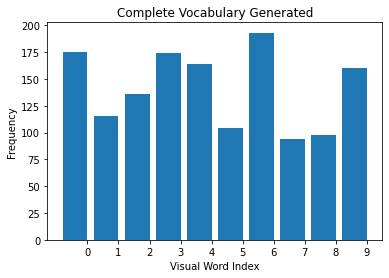

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 164.20898914337158 seconds ---


In [10]:
train_path = "input/train"
test_path = "input/test"
no_clusters = 10
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features, descriptors, train_labels = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

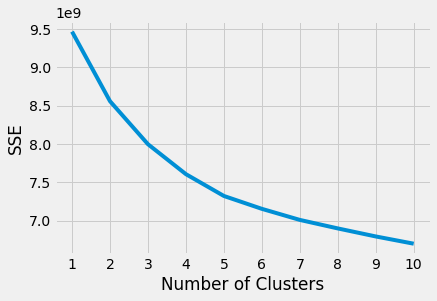

In [11]:
cluster_elbow(descriptors)

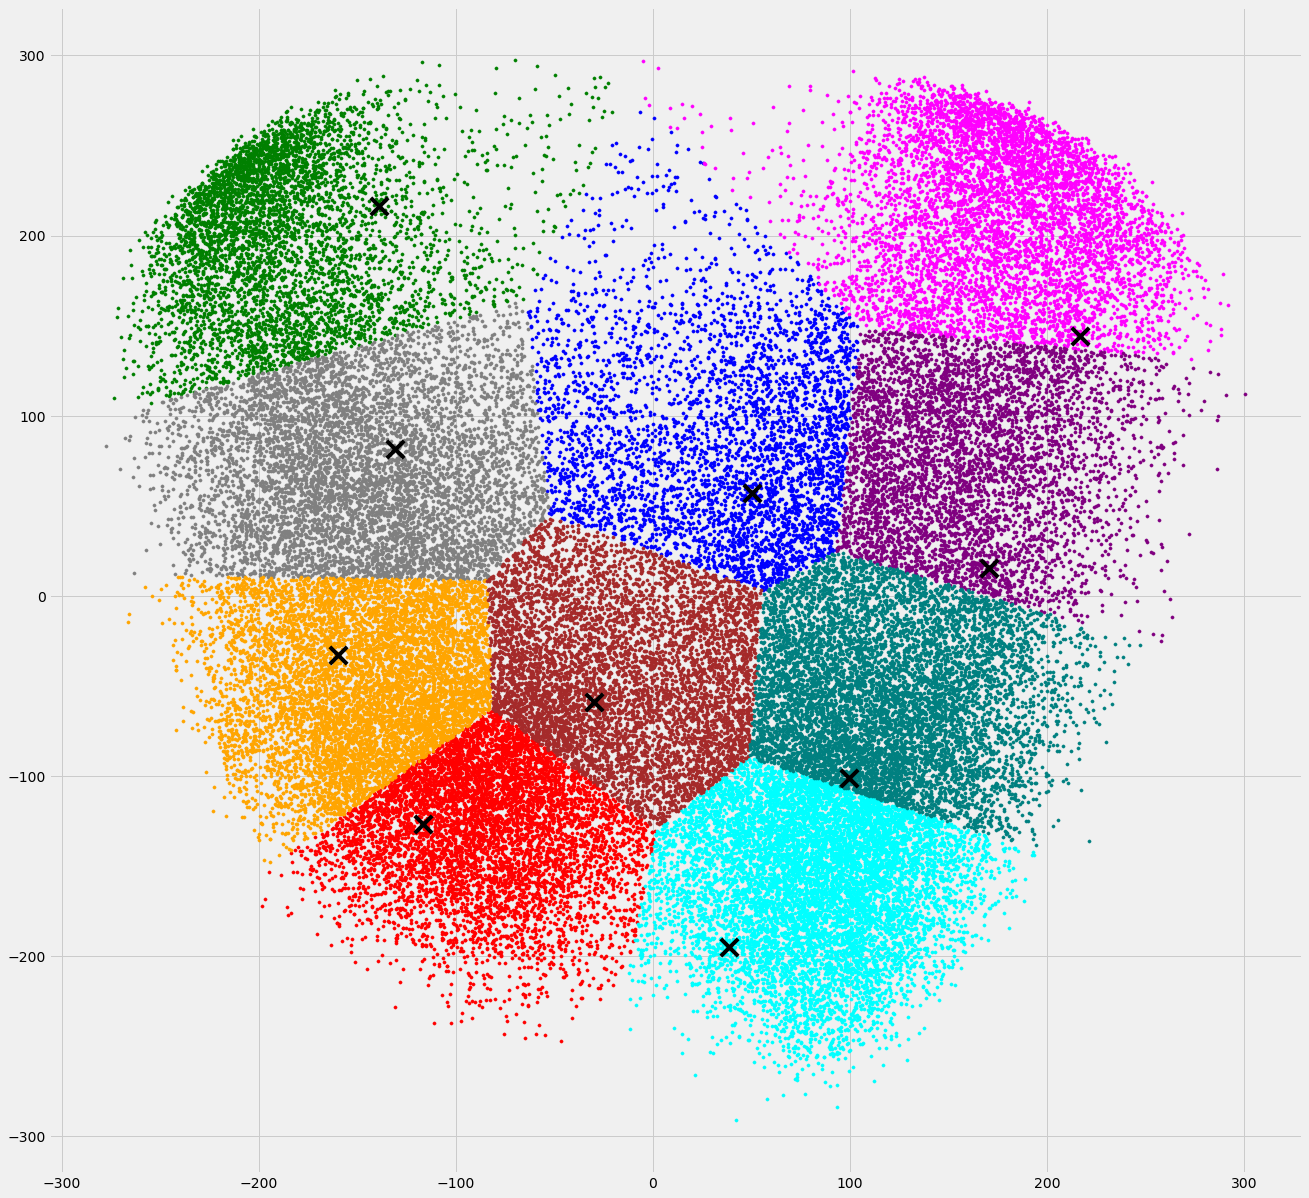

In [12]:
kmean_cluster(10, descriptors)

In [13]:
len(train_labels)

800

In [20]:
silhouette_score(im_features, train_labels, metric='euclidean', sample_size=None, random_state=0)

-0.07152683156827144

## Testing and Data Prepration 

In [15]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []
    
    name_dict = {}
    for cls in range(10):
        name_dict[cls]=cls+1
    name_dict

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)
            
            true.append(int(img_path.split('/')[2].lstrip('0')))

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[int(i)] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")
    
    return descriptors, test_features, true, predictions

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[ 2  1  0  1  4 10  0  0  0  2]
 [ 0 12  5  1  0  0  0  2  0  0]
 [ 0  9  7  2  1  0  0  0  1  0]
 [ 1  3  2  7  0  1  1  3  1  1]
 [ 0  0  1  1  9  2  2  2  0  3]
 [ 2  5  0  1  1 10  1  0  0  0]
 [ 2  1  0  1  1  2  5  3  2  3]
 [ 1  0  1  4  2  1  0  8  1  2]
 [ 0  0  0  1  1  0  0  7 11  0]
 [ 2  0  0  0  4  1  0  1  3  9]]


/tmp/ipykernel_21821/2335507161.py:146: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


Normalized confusion matrix
[[0.1  0.05 0.   0.05 0.2  0.5  0.   0.   0.   0.1 ]
 [0.   0.6  0.25 0.05 0.   0.   0.   0.1  0.   0.  ]
 [0.   0.45 0.35 0.1  0.05 0.   0.   0.   0.05 0.  ]
 [0.05 0.15 0.1  0.35 0.   0.05 0.05 0.15 0.05 0.05]
 [0.   0.   0.05 0.05 0.45 0.1  0.1  0.1  0.   0.15]
 [0.1  0.25 0.   0.05 0.05 0.5  0.05 0.   0.   0.  ]
 [0.1  0.05 0.   0.05 0.05 0.1  0.25 0.15 0.1  0.15]
 [0.05 0.   0.05 0.2  0.1  0.05 0.   0.4  0.05 0.1 ]
 [0.   0.   0.   0.05 0.05 0.   0.   0.35 0.55 0.  ]
 [0.1  0.   0.   0.   0.2  0.05 0.   0.05 0.15 0.45]]


/tmp/ipykernel_21821/2335507161.py:146: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


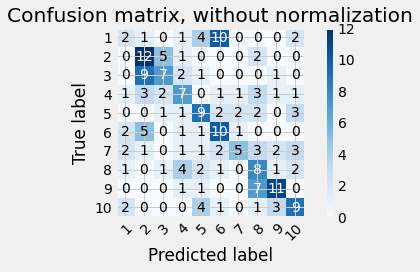

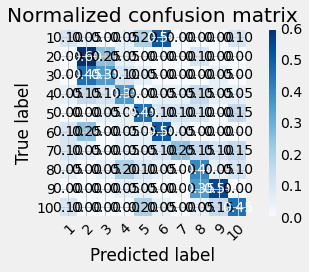

Confusion matrixes plotted.
accuracy score: 0.400
Accuracy calculated.
Execution done.
--- 38.081329584121704 seconds ---


In [16]:
start_time = time.time()
descriptors, test_features, true, predictions = testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
sift_view(train['00005'][0])

NameError: name 'train' is not defined

In [18]:
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           1       0.20      0.10      0.13        20
           2       0.39      0.60      0.47        20
           3       0.44      0.35      0.39        20
           4       0.37      0.35      0.36        20
           5       0.39      0.45      0.42        20
           6       0.37      0.50      0.43        20
           7       0.56      0.25      0.34        20
           8       0.31      0.40      0.35        20
           9       0.58      0.55      0.56        20
          10       0.45      0.45      0.45        20

    accuracy                           0.40       200
   macro avg       0.40      0.40      0.39       200
weighted avg       0.40      0.40      0.39       200



In [50]:
cnf_matrix = confusion_matrix(true, predictions)
print(cnf_matrix)

[[ 2  1  0  1  4 10  0  0  0  2]
 [ 0 12  5  1  0  0  0  2  0  0]
 [ 0  9  7  2  1  0  0  0  1  0]
 [ 1  3  2  7  0  1  1  3  1  1]
 [ 0  0  1  1  9  2  2  2  0  3]
 [ 2  5  0  1  1 10  1  0  0  0]
 [ 2  1  0  1  1  2  5  3  2  3]
 [ 1  0  1  4  2  1  0  8  1  2]
 [ 0  0  0  1  1  0  0  7 11  0]
 [ 2  0  0  0  4  1  0  1  3  9]]


In [69]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

scores = []
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
scores.append(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
scores.append(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
scores.append(PPV)

# Negative predictive value
NPV = TN/(TN+FN)
scores.append(NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
scores.append(FPR)

# False negative rate
FNR = FN/(TP+FN)
scores.append(FNR)

# False discovery rate
FDR = FP/(TP+FP)
scores.append(FDR)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
scores.append(ACC)

np_scores=np.array(scores)

In [88]:
import seaborn as sns

<AxesSubplot:>

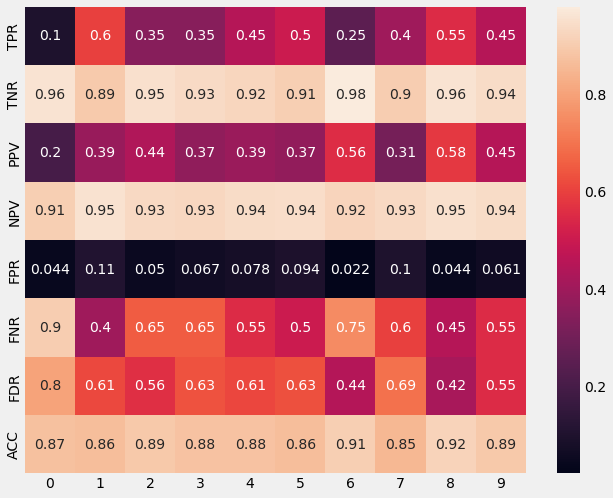

In [99]:
plt.figure(figsize=(10,8))
sns.heatmap(np_scores, annot=True, yticklabels=['TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC'])